In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

%matplotlib inline
torch.manual_seed(1)

In [4]:
import gym
env = gym.make('Pong-v0')

In [22]:
type(env.observation_space.sample())

numpy.ndarray

In [2]:
word_to_ix = {"hello": 0, "world": 1}
embeds = nn.Embedding(2, 5)  # 2 words in vocab, 5 dimensional embeddings
lookup_tensor = torch.tensor([word_to_ix["hello"]], dtype=torch.long)
hello_embed = embeds(lookup_tensor)
world_embed = embeds(torch.tensor(1))
print(hello_embed)
print(world_embed)

embeds_2 = nn.Embedding(2,2)
print(type(embeds_2(torch.tensor(0))))
print(embeds_2(torch.tensor(0)))
print(embeds_2(torch.tensor(1)))

tensor([[ 0.6614,  0.2669,  0.0617,  0.6213, -0.4519]],
       grad_fn=<EmbeddingBackward>)
tensor([-0.1661, -1.5228,  0.3817, -1.0276, -0.5631],
       grad_fn=<EmbeddingBackward>)
<class 'torch.Tensor'>
tensor([-0.8923, -0.0583], grad_fn=<EmbeddingBackward>)
tensor([-0.1955, -0.9656], grad_fn=<EmbeddingBackward>)


In [3]:
EMBEDDING_DIM = 10
# We will use Shakespeare Sonnet 2
test_sentence = """When forty winters shall besiege thy brow,
And dig deep trenches in thy beauty's field,
Thy youth's proud livery so gazed on now,
Will be a totter'd weed of small worth held:
Then being asked, where all thy beauty lies,
Where all the treasure of thy lusty days;
To say, within thine own deep sunken eyes,
Were an all-eating shame, and thriftless praise.
How much more praise deserv'd thy beauty's use,
If thou couldst answer 'This fair child of mine
Shall sum my count, and make my old excuse,'
Proving his beauty by succession thine!
This were to be new made when thou art old,
And see thy blood warm when thou feel'st it cold.""".split()

In [4]:
test_tuple = [([test_sentence[i],test_sentence[i+1]],test_sentence[i+2]) for i,_ in enumerate(test_sentence[:-2])]

In [5]:
vocab = set(test_sentence)
sentence_embeddings = nn.Embedding(len(vocab),EMBEDDING_DIM)
sentence_idx = {k:i for i,k in enumerate(vocab)}

In [76]:
class NGramLanguageModeler(nn.Module):
    def __init__(self,vocab_size,embedding_dim,context_size):
        super(NGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size,embedding_dim)
        self.linear1 = nn.Linear(context_size*embedding_dim,128)
        self.linear2 = nn.Linear(128,vocab_size)
        
    def forward(self,words_idx):
        word_embeddings = self.embeddings(words_idx).view((1, -1)) #[self.embeddings(torch.tensor(i)) for i in words_idx]
        x = F.relu(self.linear1(word_embeddings))
        x = F.log_softmax(self.linear2(x),dim=1)
        return x

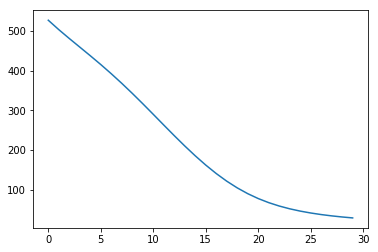

In [83]:
# training ngram
## Using dtype = torch.long is important here!
losses = []
lossFunc = nn.NLLLoss()
vocab_size = len(vocab)
CONTEXT_SIZE = 2
nnGram = NGramLanguageModeler(vocab_size,EMBEDDING_DIM,CONTEXT_SIZE)
optimizer = optim.SGD(nnGram.parameters(),lr=0.001,momentum=0.9)
epochs = 30
for _ in range(epochs):
    total_loss = 0
    for data in test_tuple:
        words_idx = torch.tensor([sentence_idx[elem] for elem in data[0]],dtype=torch.long)
        
        optimizer.zero_grad()
        next_word_probs = nnGram(words_idx)
        loss = lossFunc(next_word_probs,torch.tensor([sentence_idx[data[1]]],dtype=torch.long))
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    losses.append(total_loss)
plt.plot(losses)
plt.show()